In [1]:
import numpy as np
import pandas as pd
import os

dataset_directory = '/kaggle/input/' #import libraries

#import trainset 

In [2]:
df_train = pd.read_csv(os.path.join(dataset_directory, "cassava-leaf-disease-classification/train.csv"))

In [3]:
df_train.head() #first few rows

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [4]:
import json

# Read json to get the dictionary of the label names
with open(os.path.join(dataset_directory, "cassava-leaf-disease-classification/label_num_to_disease_map.json")) as file:
    data = json.load(file)

print(data)

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


In [5]:
df_train["label"] = df_train["label"].astype(str)
df_train['Label name'] = df_train['label'].map(data) #change data type string and map data

In [6]:
df_train.head() #using labelname 

,image_id,label,Label name
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD)
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD)


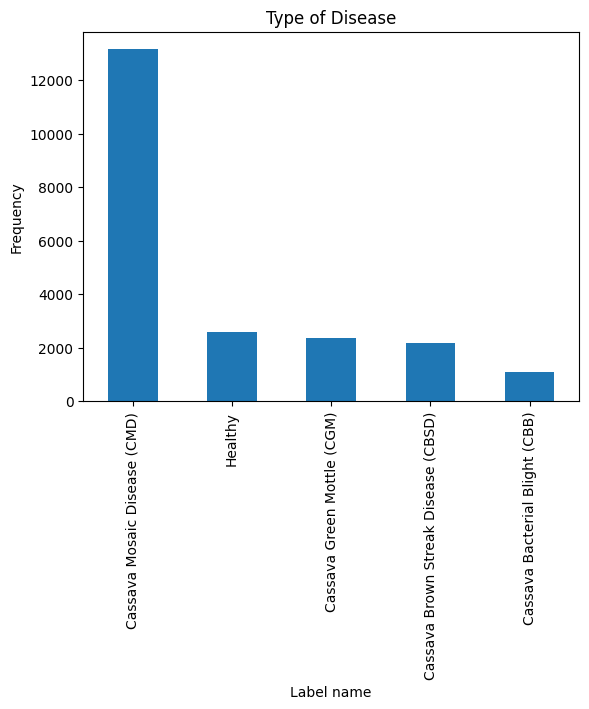

In [7]:
import matplotlib.pyplot as plt
value_counts = df_train["Label name"].value_counts()

value_counts.plot(kind='bar')
plt.ylabel('Frequency')
plt.title('Type of Disease')
plt.show()
#plot frequency with disease

In [8]:
#Plot some images
import cv2
directory = os.path.join(dataset_directory, "cassava-leaf-disease-classification", "train_images")
image_files = [os.path.join(directory, f) 
               for f in os.listdir(directory) if os.path.isfile(os.path.join(directory,f))]

In [9]:
image_files_example = image_files[1:10] #check image files

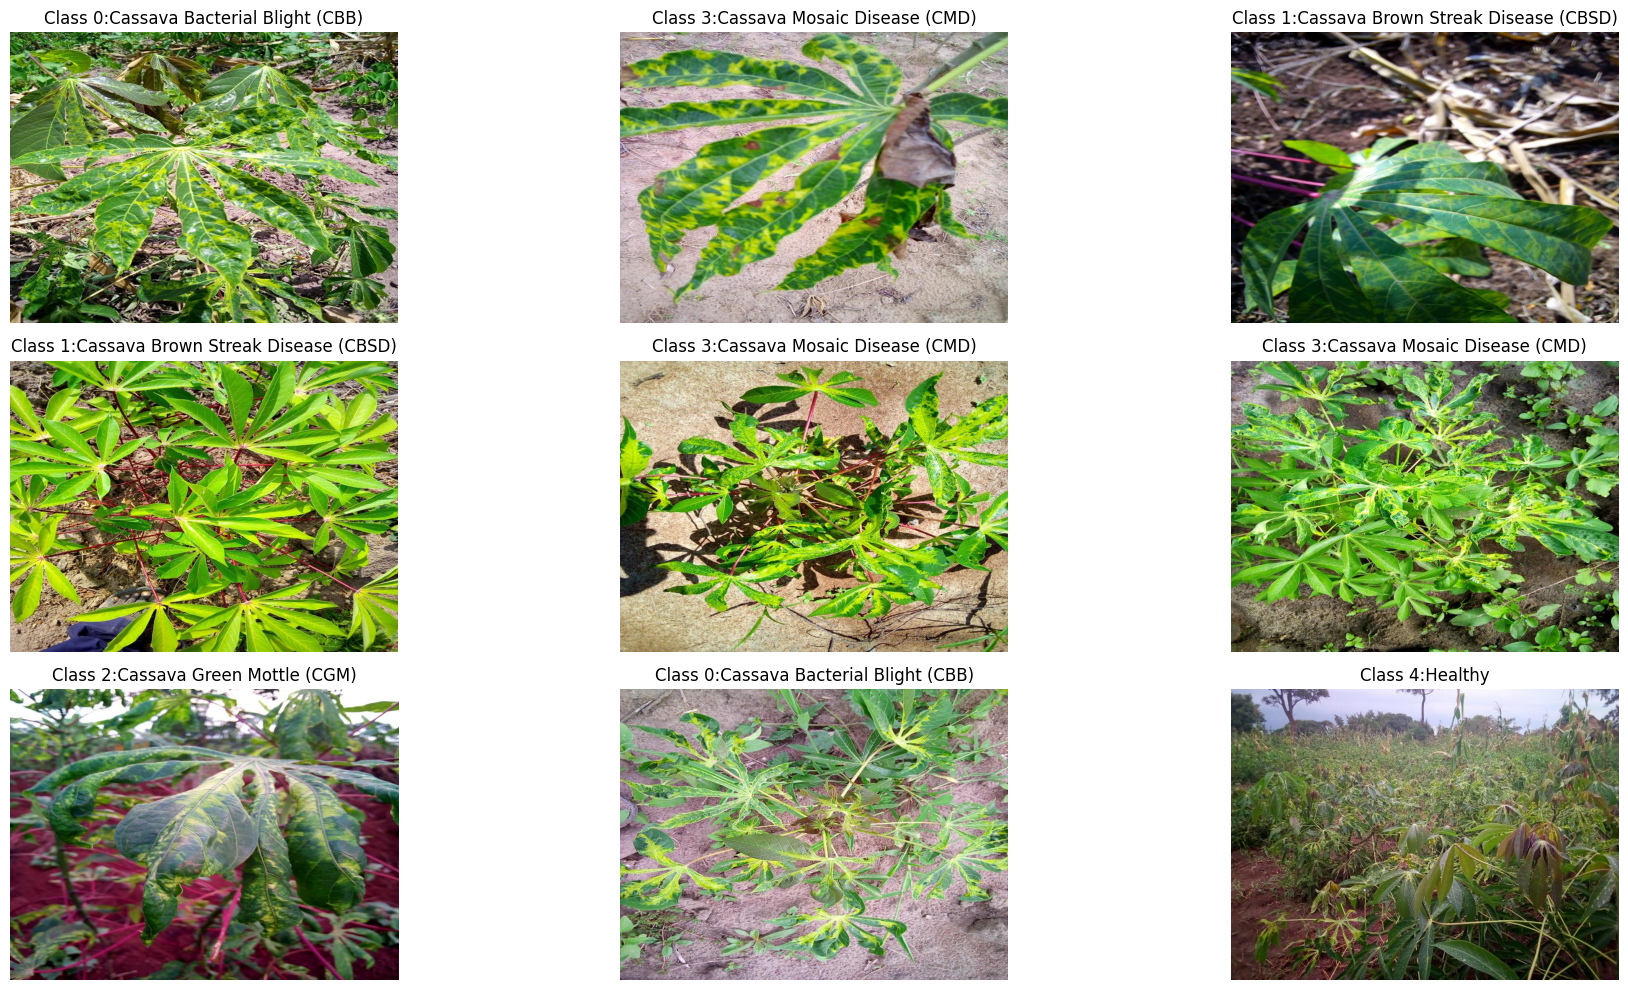

In [10]:
# Set the number of images per row
images_per_row = 3

# Rows needed
num_rows = len(image_files_example) // images_per_row + (1 if len(image_files_example) % images_per_row else 0)

# Plot each image
plt.figure(figsize=(20,10)) 
for idx, image_path in enumerate(image_files_example):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib

    plt.subplot(num_rows, images_per_row, idx + 1)
    plt.imshow(img_rgb)
    plt.title("Class "+df_train["label"].loc[idx]+ ":" +df_train["Label name"].loc[idx])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [11]:
#Shape of Images
image_example = cv2.imread(image_files_example[1])


In [12]:
image_example.shape

(600, 800, 3)

In [13]:
#ResNet50
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

2024-04-08 10:42:46.922355: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 10:42:46.922460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 10:42:47.051935: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [14]:
#Importing base model without input layer
base_model = ResNet50(weights='imagenet', include_top=False,input_shape=(600, 800, 3))

94765736/94765736 [==============================] - 3s 0us/step


In [15]:
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add a global spatial average pooling layer
x = Dense(1024, activation='relu')(x)  # Add a fully-connected layer
predictions = Dense(5, activation='softmax')(x) #The output layer, with 5 classes

In [16]:
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 600, 800, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 606, 806, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 300, 400, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 300, 400, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [18]:
df_train['image_path'] = df_train['image_id'].apply(lambda x: f'{directory}/{x}')

# Initialize the ImageDataGenerator
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  #80% training, 20% Validation
)

# Now, use flow_from_dataframe to link your DataFrame with the generator
train_generator = data_generator.flow_from_dataframe(
    dataframe=df_train,
    directory=None,  # Set to None because 'image_path' contains full paths
    x_col='image_path',  # Column with image paths
    y_col='label',  # Column with labels
    #target_size=(224, 224),  # ResNet50 and VGG16 input size
    batch_size=64,
    class_mode='categorical', 
    subset='training'  
)
validation_generator = data_generator.flow_from_dataframe(
    dataframe=df_train,
    directory=None,  
    x_col='image_path',  
    y_col='label',  
    #target_size=(224, 224),  
    batch_size=64,
    class_mode='categorical',  
    subset='validation' 
)

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


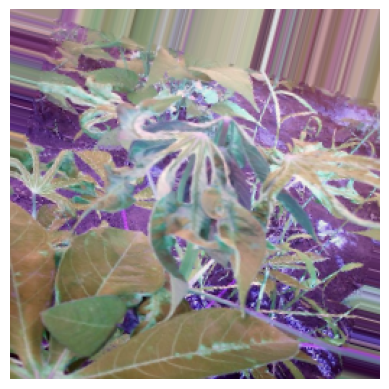

In [19]:
#Plotting image from image generator
images, labels = next(train_generator)

# Select the first image from the batch
image = images[1]
image = (image - np.min(image)) / (np.max(image) - np.min(image))

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

In [20]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=7
)

Epoch 1/7


I0000 00:00:1712573029.879031     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


267/267 [==============================] - 499s 2s/step - loss: 0.9082 - accuracy: 0.6912 - val_loss: 0.7660 - val_accuracy: 0.7083
Epoch 2/7
267/267 [==============================] - 386s 1s/step - loss: 0.7277 - accuracy: 0.7341 - val_loss: 0.7346 - val_accuracy: 0.7377
Epoch 3/7
267/267 [==============================] - 368s 1s/step - loss: 0.6784 - accuracy: 0.7539 - val_loss: 0.7034 - val_accuracy: 0.7450
Epoch 4/7
267/267 [==============================] - 368s 1s/step - loss: 0.6575 - accuracy: 0.7606 - val_loss: 0.6751 - val_accuracy: 0.7524
Epoch 5/7
267/267 [==============================] - 400s 1s/step - loss: 0.6449 - accuracy: 0.7614 - val_loss: 0.6706 - val_accuracy: 0.7585
Epoch 6/7
267/267 [==============================] - 375s 1s/step - loss: 0.6352 - accuracy: 0.7695 - val_loss: 0.6773 - val_accuracy: 0.7571
Epoch 7/7
267/267 [==============================] - 383s 1s/step - loss: 0.6226 - accuracy: 0.7750 - val_loss: 0.6546 - val_accuracy: 0.7642


In [21]:
train_accuracy = history.history['accuracy']

val_accuracy = history.history['val_accuracy']

print(f"Training Accuracy: {train_accuracy[0]}")
print(f"Validation Accuracy: {val_accuracy[0]}") #accuracy

Training Accuracy: 0.6912161111831665
Validation Accuracy: 0.7083333134651184


In [22]:
model.save('ResNet50_trained_model.keras')

In [23]:
from pathlib import Path

# Path
model_path = 'ResNet50_trained_model.keras'

model_file = Path(model_path)
print(model_file)

ResNet50_trained_model.keras


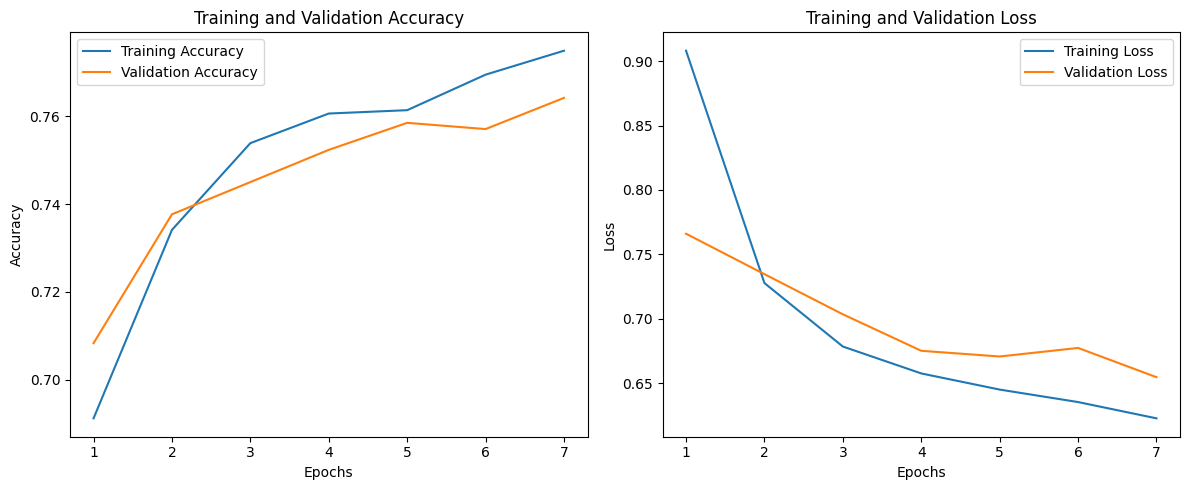

In [24]:
#Graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
#Prediction
test_image_path = os.path.join(dataset_directory, "cassava-leaf-disease-classification/test_images/2216849948.jpg")
test_image = cv2.imread(test_image_path)
print(test_image.shape)

(600, 800, 3)


In [26]:
image_batch = np.expand_dims(test_image, axis=0)
predictions = model.predict(image_batch)

predicted_class = np.argmax(predictions, axis=1)
print("Predicted class:", predicted_class)
print(type(predicted_class))

1/1 [==============================] - 2s 2s/step
Predicted class: [4]
<class 'numpy.ndarray'>
